# A quick stardate tutorial: measuring the ages of rotating stars

In this tutorial we'll infer the ages of some Kepler targets with measured rotation periods.

We'll start by downloading the McQuillan *et al.* (2014) (https://arxiv.org/abs/1402.5694) catalogue of stellar rotation periods.

In [1]:
import pandas as pd

url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)

In order to get some photometric colors for these stars (which is the minimum requirement to measure a *stardate* age), as well as some parallaxes, which will improve the age estimate, let's find these stars in the Gaia DR2 catalogue. Thankfully, we don't have to crossmatch targets ourselves because Megan Bedell has already done it for us (check out https://gaia-kepler.fun). Her table also contains useful information from the Kepler input catalogue. Let's download the Gaia-Kepler crossmatch.

In [2]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data)

Now let's merge these two data frames to make one data frame containing rotation periods, Gaia parallaxes, colours, etc. If we did this naively we'd run into memory problems because the gaia dataframe is too large (even when just restricted to the Kepler sample). So first we'll create a new database with only the columns we want.

In [3]:
mini_gaia = pd.DataFrame(dict({"source_id": gaia.source_id,
                               "kepid": gaia.kepid,
                               "ra": gaia.ra,
                               "dec": gaia.dec,
                               "parallax": gaia.parallax,
                               "parallax_error": gaia.parallax_error,
                               "G": gaia.phot_g_mean_mag,
                               "bp": gaia.phot_bp_mean_mag,
                               "rp": gaia.phot_rp_mean_mag,
                               "jmag": gaia.jmag,
                               "hmag": gaia.hmag,
                               "kmag": gaia.kmag,
                              }))

df = pd.merge(mc, mini_gaia, left_on="KID", right_on="kepid", how="inner")

Now we have everything we need (and more!) to start measuring ages. First, let's plot these stars on a (crude) colour-magnitude diagram and colour them by their rotation periods.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log10


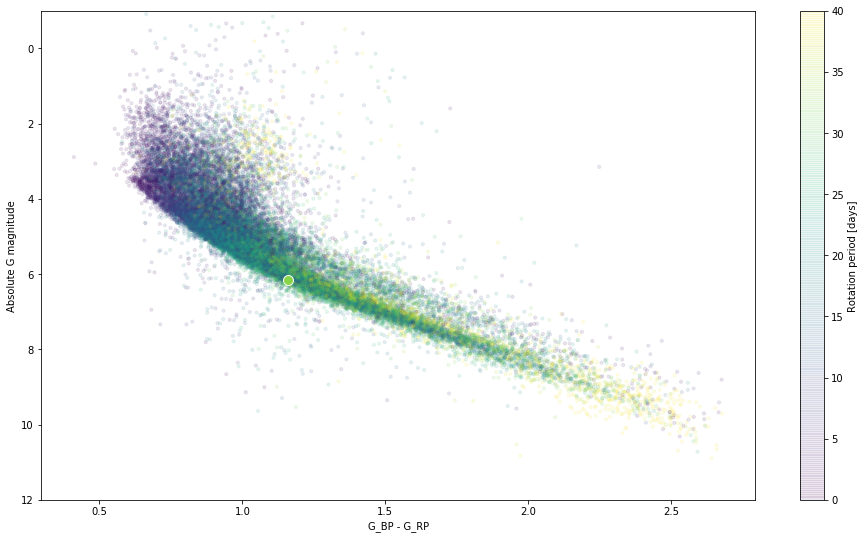

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D) + 5

abs_G = m_to_M(df.G, (1./df.parallax)*1e3)

plt.figure(figsize=(16, 9))
plt.scatter(df.bp - df.rp, abs_G, c=df.Prot, s=10, alpha=.1, vmin=0, vmax=40);
plt.gca().invert_yaxis()
plt.ylim(12, -1)
plt.colorbar(label="Rotation period [days]")
plt.xlabel("G_BP - G_RP")
plt.ylabel("Absolute G magnitude");

np.random.seed(1234)
ind = np.random.randint(0, len(df))
plt.scatter(df.bp[ind] - df.rp[ind], abs_G[ind], c=df.Prot[ind], s=100, vmin=0, vmax=40, edgecolor="w")

In this figure you can see that the lowest mass stars (bottom right) are rotating slowly and stars rotate more and more rapidly as they increase in mass. On the main sequence, stars of the same mass rotate more slowly as they get older and move up the y-axis. You can also see the binary sequence. On average, binary stars spin more rapidly than single stars. In this version of stardate we do not account for the possibility that a star might be in a binary.

# Inferring a stellar age

Now let's measure the age of a random star in this data set. We'll use the randomly chosen star plotted as a large circle on the CMD above.

We'll start by creating a dictionary of observables for this star. These are just the observables that provide information about the amount of hydrogen left in a star's core (i.e. placement on a stellar evolution track) which will be passed to the *isochrones* isochrone fitting algorithm. These observables could include photometric colours, atmospheric properties (effective temperature, surface gravity and metallicity), parallax, and even asteroseismic parameters. For most Kepler stars, only broad-band photometry is available so that's what we'll use here.

In [6]:
import stardate as sd

iso_params = {"G": (df.G[ind], .05),  # We'll just estimate the uncertainties for now.
              "bp": (df.bp[ind], .05),   
              "rp": (df.rp[ind], .05),
              "J": (df.jmag[ind], .05),
              "H": (df.hmag[ind], .05),
              "K": (df.kmag[ind], .05),
              "parallax": (df.parallax[ind], df.parallax_error[ind])}  # Parallax in milliarcseconds.

In [ ]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"G": (14.6, .05),        # Gaia G-band magnitude
              "bp": (15.14, .05),      # Gaia G_BP magnitude  
              "rp": (14.00, .05),      # Gaia G_RP magnitude  
              "parallax": (1., .001)}  # Parallax in milliarcseconds

prot, prot_err = 26., 1.

# Set up the star object
star = sd.star(iso_params, prot, prot_err)  # Here's where you add a rotation period
star.fit()  # Run the MCMC

In [ ]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"teff": (5777, 10),     # Teff with uncertainty
              "logg": (4.44, .05),    # logg with uncertainty
              "feh": (0., .001),      # Metallicity with uncertainty
              "parallax": (1., .01)}  # Parallax in milliarcseconds

prot, prot_err = 26., 1.

# Set up the star object
star = sd.star(iso_params, prot, prot_err)  # Here's where you add a rotation period
star.fit()  # Run the MCMC

In [ ]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"teff": (5777, 10),     # Teff with uncertainty
              "logg": (4.44, .05),    # logg with uncertainty
              "feh": (0., .001),      # Metallicity with uncertainty
              "delta_nu": (136, 1.),  # Large frequency separation in uHz
              "nu_max": (3150, 100.), # Frequency of maximum power in uHz
              "parallax": (1., .01)}  # Parallax in milliarcseconds

prot, prot_err = 26., 1.

# Set up the star object
star = sd.star(iso_params, prot, prot_err)  # Here's where you add a rotation period
star.fit()  # Run the MCMC

Pay attention to the exact format of the iso_params dictionary. The *isochrones* package requires it to be in exactly this format. Observables should be tuples containing values and uncertainties and this should **not be a pandas dictionary!** In addition, a new iso_params dictionary should be created for every star -- *isochrones* will not currently accept arrays of multiple stars). I'll walk you through running *stardate* on multiple stars later in this tutorial.

Now let's set up the star object. This is where we'll add the rotation period (Prot) and rotation period uncertainty (Prot_err).

In [6]:
star = sd.star(iso_params, df.Prot[ind], df.Prot_err[ind], savedir=".", filename="{}".format(df.KID[ind]));

The savedir argument should be the path to the directory you'd like the posterior samples to be saved in. The default is the current working directory. The filename is the name you'd like to give to the h5 file that will contain the save posterior samples. The default is "samples". It's useful to set this to the name or id of the star if you're running *stardate* on multiple stars.

Now all we need to do is run the MCMC and wait a few minutes (usually around 10).

In [ ]:
star.fit()

# Accessing and plotting the results.

Let's print the median value of age and it's 16th and 84th percentile uncertainties.

In [8]:
median_age, age_errp, age_errm, age_samples = star.age_results()
age_gyr = (10**median_age)*1e-9
print("log10(age) = {0:.2f} + {1:.2f} - {2:.2f}".format(median_age, age_errp, age_errm))
print("Age = {0:.2f} + {1:.2f} - {2:.2f} gyr".format(age_gyr, 
                                                     (10**(median_age + age_errp))*1e-9 - age_gyr,
                                                     abs(age_gyr - (10**(median_age + age_errm))*1e-9)))

log10(age) = 9.70 + 0.04 - 0.32
Age = 4.99 + 0.43 - 5.39 gyr


We can do the same thing for mass, metallicity, distance and extinction:

In [9]:
mass, mass_errp, mass_errm, mass_samples = star.mass_results()
print("Mass = {0:.2f} + {1:.2f} - {2:.2f} gyr".format(mass, mass_errp, mass_errm))

feh, feh_errp, feh_errm, feh_samples = star.feh_results()
print("feh = {0:.2f} + {1:.2f} - {2:.2f} gyr".format(feh, feh_errp, feh_errm))

distance, distance_errp, distance_errm, distance_samples = star.distance_results()
print("distance = {0:.2f} + {1:.2f} - {2:.2f} gyr".format(distance, distance_errp, distance_errm))

Av, Av_errp, Av_errm, Av_samples = star.Av_results()
print("Av = {0:.2f} + {1:.2f} - {2:.2f} gyr".format(Av, Av_errp, Av_errm))

Mass = 0.78 + 0.03 - 0.07 gyr
feh = -0.09 + 0.23 - 0.18 gyr
distance = 6.21 + 0.01 - 0.06 gyr
Av = 0.09 + 0.07 - 0.15 gyr


Now we'll plot a histogram of the marginalized posterior over stellar age.

Text(0.5,0,'log10(Age)')

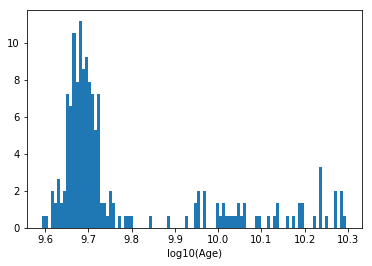

In [10]:
plt.hist(age_samples, 100, normed=True);
plt.xlabel("log10(Age)")

And let's make a corner plot.

(168, 5)


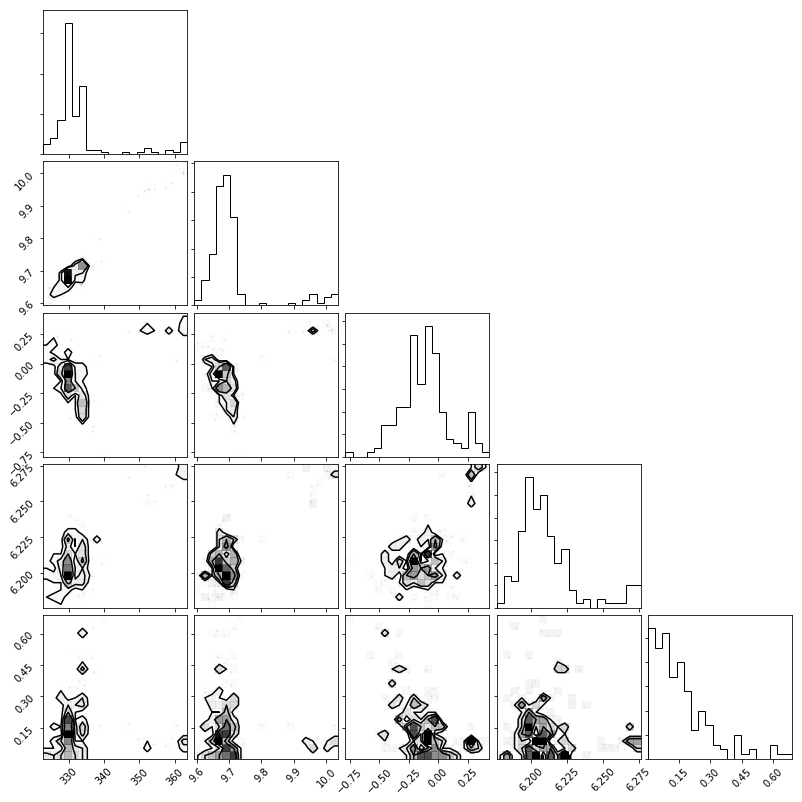

In [11]:
import corner
print(np.shape(star.samples))
corner.corner(star.samples);

# Multiple stars

Looping over multiple stars could look something like this:

In [12]:
N = 10  # Measure ages for the first 10 stars in the McQuillan catalog
results = np.empty((N, 5))  # There are 5 dimensions: EEP, age, feh, distance and Av

for i in range(10):
    
    # You have to set up the parameter dictionary for every star.
    iso_params = {"G": (df.G[i], .05),
                  "bp": (df.bp[i], .004),    
                  "rp": (df.rp[i], .004),
                  "J": (df.jmag[i], .05),
                  "H": (df.hmag[i], .05),
                  "K": (df.kmag[i], .05),
                  "parallax": (df.parallax[i], df.parallax_error[i])}  # Parallax in milliarcseconds.
    
    star.fit()
    print(np.shape(star.samples()))
    print(np.shape(np.median(star.samples(), axis=0)))
    results[i, :] = np.median(star.samples(), axis=0)

  0%|          | 100/100000 [00:01<24:06, 69.04it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:324: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:325: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 391/100000 [00:03<11:57, 138.91it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:325: RuntimeWarning: divide by zero encountered in true_divide
  co

emcee: Exception while calling your likelihood function:
  params: [ 3.26571773e+02  9.61705873e+00 -5.23524747e-02  6.18715939e+00
  2.54959095e-01]
  args: [<isochrones.starmodel.StarModel object at 0x170225a90>, 32.965, 0.7170000000000001, None, None, False, False]
  kwargs: {}
  exception:


KeyboardInterrupt: 

# Isochrone fitting only

It's also possible to switch off gyrochronology and just infer an age using isochrones only. This is useful if you'd like to predict ages for a list of stars where only some of them have rotation periods. There are a couple of different ways to do this. The simplest way is just to pass 'None' instead of a period and period uncertainty:

In [13]:
star = sd.star(iso_params, None, None)

Passing zeros instead of Nones will also work. It's best, but not crucial, to also set the 'isochrone fitting only' key word argument to be true when you run the MCMC:

In [14]:
star.fit(iso_only=True)

  0%|          | 100/100000 [00:01<25:38, 64.95it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:324: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:325: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 300/100000 [00:03<13:40, 121.50it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:325: RuntimeWarning: invalid value encountered in true_divide
  con

# Gyrochronology only

You also have the option of using gyrochronology only and switching off isochrone fitting. This will result in a probabilisitic (Bayesian) gyrochronology age prediction. In order to use only gyrochronology however, you need to have a good idea of the B-V colour and mass of your star because these properties go into the gyrochronology age model along with rotation period. When you use gyrochronology *with* isochrones, these properties are inferred from isochrone fitting, so you have to provide them when you switch isochrone fitting off.

To use gyrochronology only, you should provide the star object with a B-V color and a mass, for example:

In [15]:
star = sd.star(iso_params, 26, 1, bv=.65, mass=1)
star.fit(gyro_only=True)

NameError: name 'mass' is not defined

# Incorporating asteroseismology

As well as apparant magnitudes, parallax and spectroscopic parameters, you can also provide asteroseismic parameters in the dictionary of observables. The dictionary below is the full set of parameters that can be provided. These parameters do not all need to be provided and can be given in any order. The precision and accurancy of inferred ages will improve as more information is provided. See the [*isochrones* documentation](https://isochrones.readthedocs.io/en/latest/api.html#starmodel) for more information.

In [ ]:
iso_params = {"G": (G, G_err),  # Gaia magnitudes
              "bp": (G_bp, G_bp_err),    
              "rp": (G_rp, G_rp_err),
              "B": (B, B_err),  
              "V": (V, V_err),
              "J": (J, J_err),
              "H": (H, H_err),
              "K": (K, K_err),
              "g": (g, g_err),  # SDSS colours -- note these are lower case.
              "r": (r, r_err),
              "i": (i, i_err),
              "z": (z, z_err),
              "teff": (teff, teff_err),  # Spectroscopic properties
              "logg": (logg, logg_err),
              "feh": (feh, feh_err),
              "nu_max": (nu_max, nu_max_err),  # Asteroseismic parameters
              "delta_nu": (delta_nu, delta_nu_err),  # Asteroseismic parameters
              "parallax": (parallax, parallax_error)}  # Parallax in milliarcseconds.